In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.DataFrame.from_csv('./dnc-temporalGraph/out.dnc-temporalGraph', sep = '\t', header = 0, index_col=None)
data = data.drop('weight', 1)
data.head()

,from,to,timestamp
0,419,465,1463507482
1,869,453,1462337903
2,943,1151,1463167636
3,943,217,1463167636
4,943,841,1463167636


In [2]:
n = np.max(data['to'])
A = np.zeros((n,n))
for index, row in data.iterrows():
    A[row['from']-1, row['to']-1] = 1 #+=1

In [3]:
import networkx as nx
G = nx.from_numpy_matrix(A,create_using=nx.DiGraph())
G.is_directed()

True

# 1 Comparing to a Random graph

We use the "Erdos-Renyi" model to compare our graph statistics with some randomly generated graph that has an expected average degree equal to our graph's average degree.

We do it in the following way.
We know that in the "Erdos-Renyi" model
 - for every different pair of nodes, $\textit{distinguishing by order for directed graphs}$, and excluding self-pointing edges
     - we draw an edge with a probability $p$
     
Since each node has $n-1$ neighbors, from each node it will draw an expected number of edges equal to

$$<k>=p(n-1) \to p n$$

so we need to set $p=<k>/(n-1) \to <k>/n$.

In [23]:
in_degree = np.mean(list(G.in_degree().values()))
out_degree = np.mean(list(G.out_degree().values()))
print('In  degree', in_degree)
print('Out degree', out_degree)
assert in_degree == out_degree
total_degree = G.in_degree()
mean_degree = np.mean(list(total_degree.values()))
p = mean_degree/(n-1)
print("Expected in or out degree: {}".format(mean_degree))
print("n: {}".format(n))
print("p: {}".format(p))
R = nx.erdos_renyi_graph(n,p,directed=True)

In  degree 2.75899457861
Out degree 2.75899457861
Expected in or out degree: 2.7589945786101526
n: 2029
p: 0.0013604509756460319


## 1.2 Comparing the graph plots

Email Graph


C:\Users\alexf\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\alexf\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\alexf\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\alexf\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is

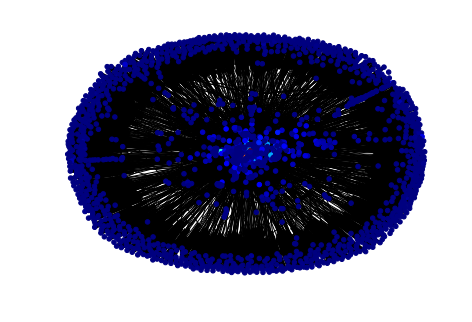

A Random Graph


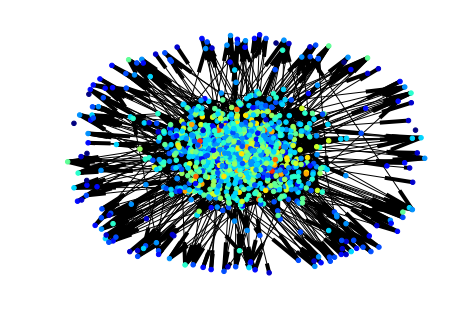

In [140]:
def draw(G):
    pos = nx.spring_layout(G)
    degree = G.degree()
    nodes = G.nodes()
    n_color = np.asarray([degree[n] for n in nodes])
    nx.draw(G, pos, node_color=n_color, node_size=20, cmap=plt.cm.jet)
    plt.show()
print('Email Graph')
draw(G)
print('A Random Graph')
draw(R)

## 1.2 Comparing the degree distribution

We observe less contrast of degree than in our graph, but a more smooth distribution from central nodes to peripherial ones, with several in the middle.

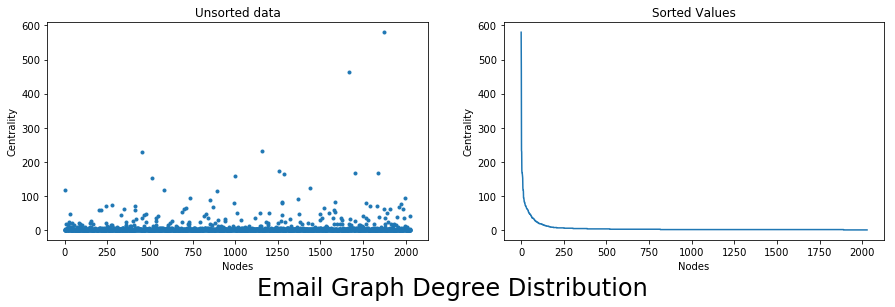

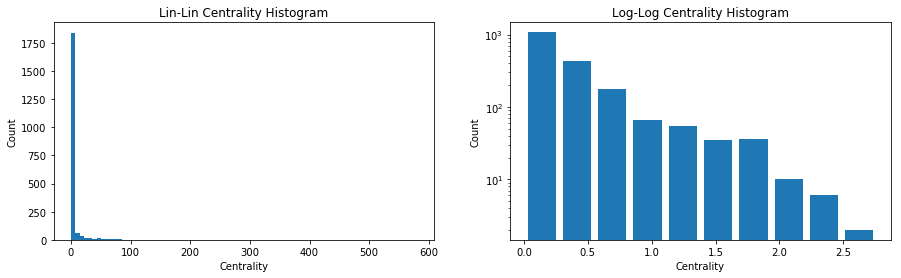

Min: 0 Max: 580 Mean: 5.52 Median: 1.0 Var: 523.12


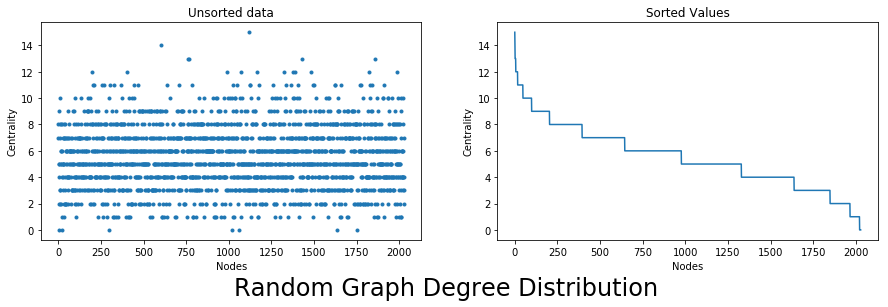

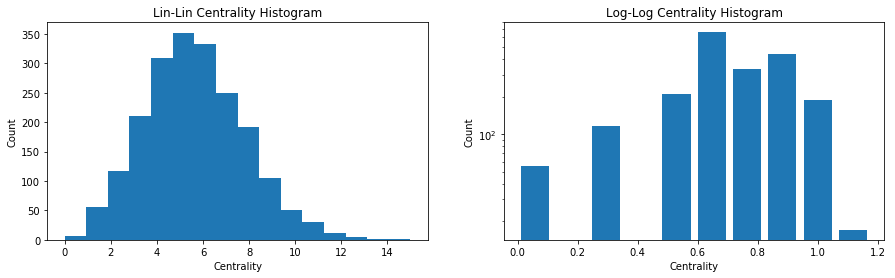

Min: 0 Max: 15 Mean: 5.52 Median: 5.0 Var: 5.34


In [177]:
def dict_summary(dic, name):
    keys = np.array(list(dic.keys()))
    vals = np.array(list(dic.values()))
    plt.figure(figsize=(15,4))
    plt.suptitle(name, fontsize=24,y=0)
    plt.subplot(1,2,1)
    plt.plot(keys,vals, '.')
    plt.title("Unsorted data");plt.ylabel("Centrality");plt.xlabel("Nodes")
    plt.subplot(1,2,2)
    plt.plot(sorted(vals, reverse=True))
    plt.title("Sorted Values");plt.ylabel("Centrality");plt.xlabel("Nodes")
    plt.show()
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.hist(vals,bins=len(set(vals)))
    plt.title("Lin-Lin Centrality Histogram");plt.ylabel("Count");plt.xlabel("Centrality")
    plt.subplot(1,2,2)
    pos_vals = vals[vals > 0]
    plt.hist(np.log10(pos_vals), log=True, rwidth=0.8)
    plt.title("Log-Log Centrality Histogram");plt.ylabel("Count");plt.xlabel("Centrality")
    plt.show()
    print("Min:",round(np.min(vals),2),"Max:",round(np.max(vals),2),
    "Mean:",round(np.mean(vals),2),"Median:",round(np.median(vals),2),
    "Var:", round(np.var(vals),2))
    
deg_G = nx.degree(G)
dict_summary(deg_G,'Email Graph Degree Distribution')
deg_R = nx.degree(R)
dict_summary(deg_R,'Random Graph Degree Distribution')

In the randomly generated graph: 
the presence of an edge is a Bernouilli variable 
$$a_{ij}\sim B(p)$$
, so the degree is the sum of $n-1$ Bernouilli variables, ie, a Binomial variable
$$k_i = \sum_{j\neq i} a_{ij} \sim B(p,n-1)$$
whose expected value is $$E[k]=p(n-1)$$ and variance $$V[k]=(n-1)*p*(1-p)$$

We observe this well by looking at the shape of the Lin-Lin Degree Centrality Histogram.

In [114]:
#factor 2 accounts for k_in+k_out degrees ( mean(k_in)==mean(k_out) )
print('Expected degree mean',2*p*(n-1))
print('Expected degree variance',2*(n-1)*p*(1-p))

Expected degree mean 5.51798915722
Expected degree variance 5.51048220349


In our graph, instead, we observe some negative power law because of the linear negative trend in the Log-Log Degree Centrality Histogram.

Also, apart from the mean, all other statistics are radically different: the mean is not a sufficient descriptor.

## 1.3 Comparing the Assortativity measure

The assorativity of a graph measures the correlation between a nodes degree and its neighbors degree:
 - High values mean that highly connected nodes connect mostly to other highly connected nodes. This can be seen in networks of collaborative nature, eg research communities...
 - Zero-like values mean independece of both facts.
 - Negative values mean that highly connected nodes connect mostly to low-connectivity nodes. This can be seen in hierarchical structures, eg an enterprise...

Our concrete values show:
- The assortativity of a random graph is around 0, due to lack of structure.
- The assortativity of our graph is negative, indicating a highly "hierarchical" structure. That means that communication happens mostly from isolated people to influent people.

In [130]:
a = nx.degree_assortativity_coefficient(G)
print("Assortativity of our graph: {}".format(a))
b = nx.degree_assortativity_coefficient(R)
print("Assortativity of random generated graph: {}".format(b))

Assortativity of our graph: -0.3029374827993258
Assortativity of random generated graph: 0.004674738384018328


As an anecdote, the degree pearson correlation and assortativity measures of NetworkX implementation output the same result...some clarification?

In [131]:
print(nx.correlation.degree_assortativity_coefficient(G))
print(nx.correlation.degree_pearson_correlation_coefficient(G))

print(nx.correlation.degree_assortativity_coefficient(R))
print(nx.correlation.degree_pearson_correlation_coefficient(R))

-0.302937482799
-0.302937482799
0.00467473838402
0.00467473838402


## 1.4 Comparing the Mean-Neighbor-Degree-vs-Degree distribution

We have observed a negative correlation between node degree and neighbors degree, but is it linear?

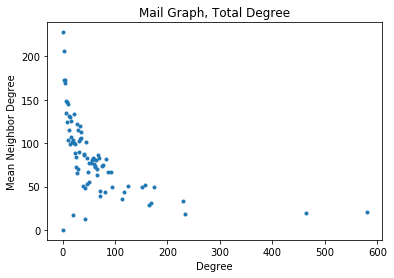

Min: 0.0 Max: 227.74 Mean: 85.02 Median: 81.13 Var: 1879.95


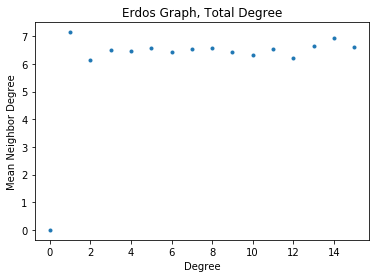

Min: 0.0 Max: 7.14 Mean: 6.12 Median: 6.51 Var: 2.55


In [257]:
def safe_add(dic,key,val):
    if key in dic:
        dic[key]+=val
    else:
        dic[key]=val

def hist(items):
    item_counts={}
    for item in items:
        safe_add(item_counts,item,1)
    return item_counts

def neighbors(G,take_in = True, take_out = True):
    neighbors = {}
    for a, b in G.edges_iter():
        if take_out:
            safe_add(neighbors,a,[b])
        if take_in:
            safe_add(neighbors,b,[a])
    return neighbors

def degrees(G, take_in = True, take_out = True):
    if take_in and take_out:
        return G.degree()
    elif take_in:
        return G.in_degree()
    elif take_out:
        return G.out_degree()

def mean_neighbor_degree(G, nn_in= True, nn_out = True, knn_in = True, knn_out = True):
    node_neighbors = neighbors(G,nn_in,nn_out)
    node_degrees = degrees(G,knn_in,knn_out)
    deg_counts = hist(node_degrees.values())
    knn = {}
    for node in node_degrees:
        degree = node_degrees[node]
        neighbor_mean = 0
        if degree > 0:
            neighbor_mean = np.mean([node_degrees[neighbor] for neighbor in node_neighbors[node]])
        safe_add(knn, degree, neighbor_mean/deg_counts[degree])
    return knn

def dict_plot(dic, title="Unsorted Data", y_label = "Values", x_label = "Keys"):
    keys = np.array(list(dic.keys()))
    vals = np.array(list(dic.values()))
    plt.plot(keys,vals, '.')
    plt.title(title);plt.ylabel(y_label);plt.xlabel(x_label)
    plt.show()
    print("Min:",round(np.min(vals),2),"Max:",round(np.max(vals),2),
    "Mean:",round(np.mean(vals),2),"Median:",round(np.median(vals),2),
    "Var:", round(np.var(vals),2))

dict_plot(mean_neighbor_degree(G),'Mail Graph, Total Degree', x_label = "Degree", y_label = "Mean Neighbor Degree")
dict_plot(mean_neighbor_degree(R),'Erdos Graph, Total Degree', x_label = "Degree", y_label = "Mean Neighbor Degree")

 We do percieve a descending trend (negative correlation) in our graph, but not exactly linear.

Note that we can consider in general the in/out degree of each node in/out neighbors. Above we consider in&out vs in&out.

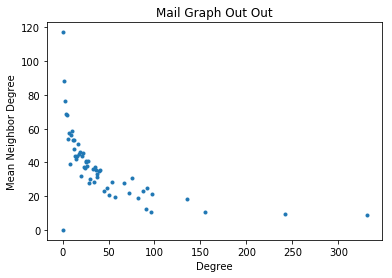

Min: 0.0 Max: 117.17 Mean: 37.76 Median: 36.24 Var: 406.44


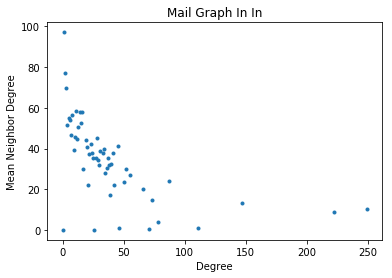

Min: 0.0 Max: 97.13 Mean: 34.94 Median: 35.41 Var: 394.32


In [261]:
dict_plot(mean_neighbor_degree(G,nn_in=False,nn_out=True,knn_in=False,knn_out=True),
          title='Mail Graph Out Out', x_label = "Degree", y_label = "Mean Neighbor Degree")
dict_plot(mean_neighbor_degree(G,nn_in=True,nn_out=False,knn_in=True,knn_out=False),
          title='Mail Graph In In', x_label = "Degree", y_label = "Mean Neighbor Degree")

Out and out (which is the default for NetworkX neighbors method) shows more consistent patterns.